# accessing data

In [44]:
# !ls
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install xarray
# !pip install gcsfs
# !pip install tqdm
# !pip install numpy

In [3]:
# Importing their table

import pandas as pd
df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/the paper/FPA-FOD_39attributes.csv", low_memory = False)
df = df[~df['NWCG_GENERAL_CAUSE'].str.contains('Missing data/not specified/undetermined', na=False)]
df["NWCG_GENERAL_CAUSE"].value_counts()

NWCG_GENERAL_CAUSE
Natural                                       3948
Debris and open burning                       1088
Arson/incendiarism                             953
Recreation and ceremony                        875
Equipment and vehicle use                      349
Power generation/transmission/distribution     154
Smoking                                         86
Fireworks                                       82
Railroad operations and maintenance             50
Misuse of fire by a minor                       44
Other causes                                    28
Firearms and explosives use                     13
Name: count, dtype: int64

# Processing data

In [4]:
unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()

In [5]:
X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y) #encode the textual output

# Splitting the data into train and test sets

In [7]:
from sklearn.model_selection import train_test_split

# Combine X and y into one DataFrame temporarily
df3 = X.copy()

df3['cause'] = y_encoded

# Split back into X and y
X = df3.drop(columns=['cause'])
y = df3['cause']

# Now do your train-test split as usual
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if isinstance(y_train_df, pd.Series):
    y_train_df = y_train_df.to_frame(name='cause')

if isinstance(y_test_df, pd.Series):
    y_test_df = y_test_df.to_frame(name='cause')

### Adding Cause Names

In [8]:
cause_names = [
    "Debris and open burning",
    "Misuse of fire by a minor",
    "Equipment and vehicle use",
    "Fireworks",
    "Arson/incendiarism",
    "Power generation/transmission/distribution",
    "Railroad operations and maintenance",
    "Recreation and ceremony",
    "Natural",
    "Smoking",
    "Other causes",
    "Firearms and explosives use"
]

# Convert y_train value counts into a DataFrame for easier mapping
counts = y_train_df.value_counts().reset_index()
counts.columns = ['cause_id', 'count']


# Map encoded ID to name
counts['cause_name'] = counts['cause_id'].map(lambda i: cause_names[i])



print(counts[['cause_id', 'cause_name', 'count']].to_string(index=False))

 cause_id                                 cause_name  count
        6        Railroad operations and maintenance   3159
        1                  Misuse of fire by a minor    871
        0                    Debris and open burning    762
       10                               Other causes    700
        2                  Equipment and vehicle use    279
        8                                    Natural    123
       11                Firearms and explosives use     69
        4                         Arson/incendiarism     66
        9                                    Smoking     40
        5 Power generation/transmission/distribution     35
        7                    Recreation and ceremony     22
        3                                  Fireworks     10


In [11]:
# Standardization
numeric_cols = X_train_df.select_dtypes(include=['number']).columns

# Compute mean and std only on numeric columns
mean = X_train_df[numeric_cols].mean()
std = X_train_df[numeric_cols].std()

# Standardize numeric columns in place
X_train_df[numeric_cols] = (X_train_df[numeric_cols] - mean) / std
X_test_df[numeric_cols] = (X_test_df[numeric_cols] - mean) / std


# y_train_df = pd.get_dummies(y_train_df).astype(float)
# y_test_df = pd.get_dummies(y_test_df).astype(float)

y_train_df2 = pd.get_dummies(y_train_df['cause'].astype(str)).astype(float)
y_test_df2 = pd.get_dummies(y_test_df['cause'].astype(str)).astype(float)
y_test_df2.head()

,0,1,10,11,2,3,4,5,6,7,8,9
8527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7418,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1413,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# # Convert sparse matrices to dense arrays
X_train = X_train_df[numeric_cols].to_numpy()
X_test = X_test_df[numeric_cols].to_numpy()
y_train = y_train_df2.to_numpy()


In [13]:
import torch 

# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))


# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/alexanderfeil/Des

# Neural Network

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


In [25]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU' #'ReLU' #'Linear', 'Tanh'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 2 # number of hidden layers
dropout_p = 0.0 #0.1 #sets probability for dropouts
weight_decay = 0 #1e-5

In [26]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [27]:

layers = []
layers.append(nn.Linear(X_train.shape[1], n_neuron))
layers.append(getattr(nn, activation)())
layers.append(nn.Dropout(dropout_p))   # <- dropout after first activation

for n in range(N_layers-1):
   layers.append(nn.Linear(n_neuron, n_neuron))
   layers.append(getattr(nn, activation)())
   layers.append(nn.Dropout(dropout_p))

layers.append(nn.Linear(n_neuron, y_train.shape[1]))

model = nn.Sequential(*layers)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay  # L2 regularization
    )
criterion = nn.MSELoss()
model.to(device)

Sequential(
  (0): Linear(in_features=38, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=12, bias=True)
)

### Single Neural Network

In [28]:
best_val_loss = float('inf')
patience_counter = 0
patience = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
   # training
   model.train()
   train_loss = 0.0
   for batch_X, batch_y in train_loader:
       batch_X = batch_X.to(device)
       batch_y = batch_y.to(device)
       # forward pass
       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       # backward pass
       loss.backward()
       optimizer.step()
       train_loss += loss.item()

    # validation
   model.eval()
   val_loss = 0.0
   with torch.no_grad():
       for batch_X, batch_y in val_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           val_loss += loss.item()
   
   train_loss /= len(train_loader)
   val_loss /= len(val_loader)

   train_losses.append(train_loss)
   val_losses.append(val_loss)
   
   print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
   else:
       patience_counter += 1
       if patience_counter >= patience:
           print(f'Early stopping at epoch {epoch+1}')
           break

Epoch 1/50, Train Loss: 0.0521, Val Loss: 0.0434
Epoch 2/50, Train Loss: 0.0406, Val Loss: 0.0411
Epoch 3/50, Train Loss: 0.0386, Val Loss: 0.0402
Epoch 4/50, Train Loss: 0.0373, Val Loss: 0.0400
Epoch 5/50, Train Loss: 0.0364, Val Loss: 0.0397
Epoch 6/50, Train Loss: 0.0357, Val Loss: 0.0395
Epoch 7/50, Train Loss: 0.0350, Val Loss: 0.0395
Epoch 8/50, Train Loss: 0.0344, Val Loss: 0.0394
Epoch 9/50, Train Loss: 0.0340, Val Loss: 0.0391
Epoch 10/50, Train Loss: 0.0335, Val Loss: 0.0389
Epoch 11/50, Train Loss: 0.0331, Val Loss: 0.0393
Epoch 12/50, Train Loss: 0.0327, Val Loss: 0.0387
Epoch 13/50, Train Loss: 0.0322, Val Loss: 0.0391
Epoch 14/50, Train Loss: 0.0319, Val Loss: 0.0394
Epoch 15/50, Train Loss: 0.0315, Val Loss: 0.0399
Epoch 16/50, Train Loss: 0.0314, Val Loss: 0.0391
Epoch 17/50, Train Loss: 0.0308, Val Loss: 0.0394
Epoch 18/50, Train Loss: 0.0304, Val Loss: 0.0399
Epoch 19/50, Train Loss: 0.0302, Val Loss: 0.0400
Epoch 20/50, Train Loss: 0.0300, Val Loss: 0.0401
Epoch 21/

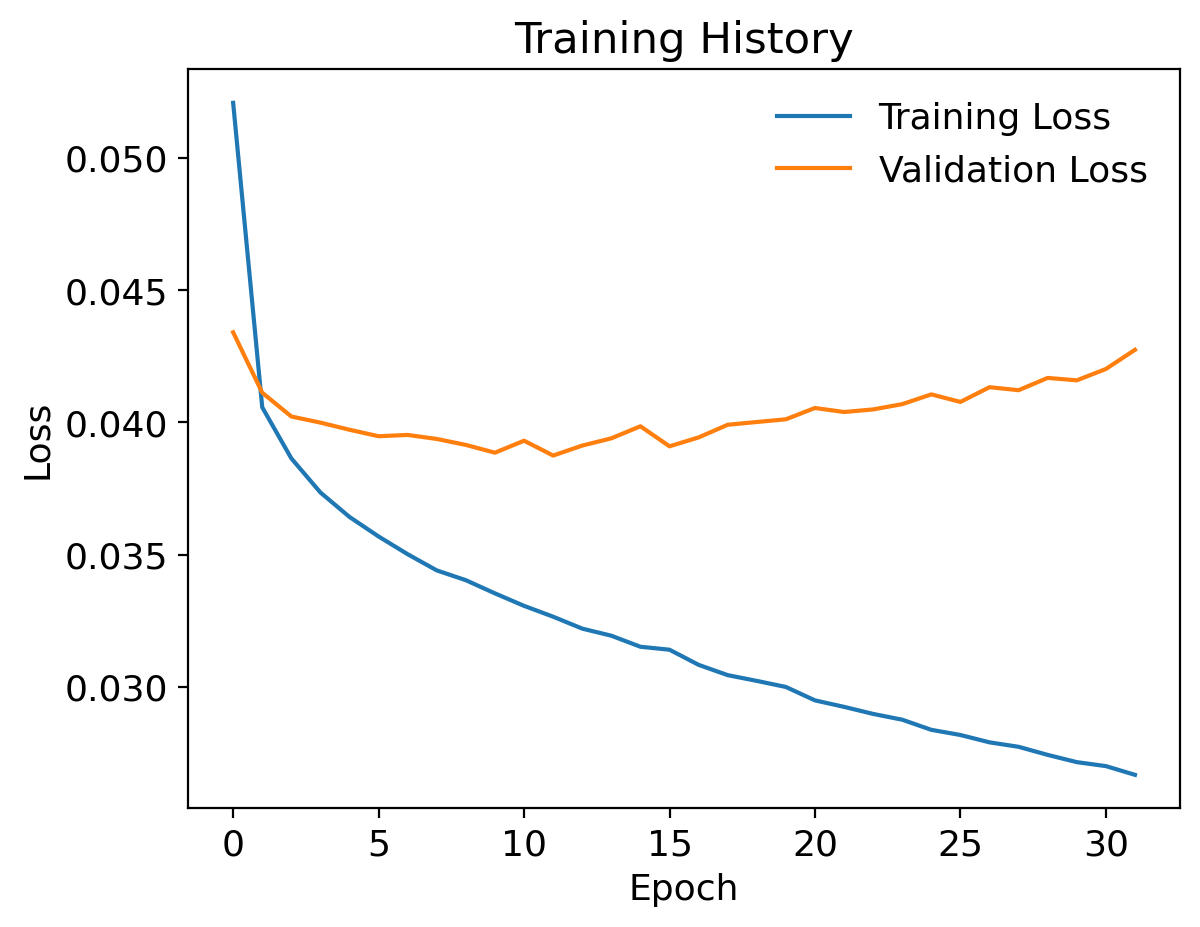

In [29]:
plot_history(train_losses, val_losses)

In [30]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [31]:
# Save the entire model to a pth file.
torch.save(model, os.path.join(model_path, 'NN_model.pth'))

In [32]:
# reload the saved model
model = torch.load(os.path.join(model_path, 'NN_model.pth'), weights_only=False)
model.to(device).eval()

Sequential(
  (0): Linear(in_features=38, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.0, inplace=False)
  (6): Linear(in_features=64, out_features=12, bias=True)
)

In [ ]:
import numpy as np
import pandas as pd
import torch.nn.functional as F

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model(batch_X)
       probs = F.softmax(outputs, dim=1)  # apply softmax to get probabilities

       # Convert tensor outputs to CPU and then to list (avoid .numpy())
       predictions.append(outputs.cpu().tolist())

# Concatenate list-of-lists into a single list
import itertools
y_test_pre_list = list(itertools.chain.from_iterable(predictions))

# After prediction and concatenation
y_test_pre = np.concatenate(predictions, axis=0)  # shape (num_samples, 12)

cause_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
y_pred_df = pd.DataFrame(y_test_pre, columns=cause_names)


# Evaluation

## RMSE

In [35]:
import numpy as np

# Flatten the DataFrames to 1D arrays (optional but commonly done)
true_values = y_test_df2.values.flatten()
pred_values = y_pred_df.values.flatten()

# Calculate RMSE
rmse = np.sqrt(np.mean((true_values - pred_values) ** 2))
print(f'RMSE: {rmse}')


RMSE: 0.1977404742547356


## Confusion Matrix Total

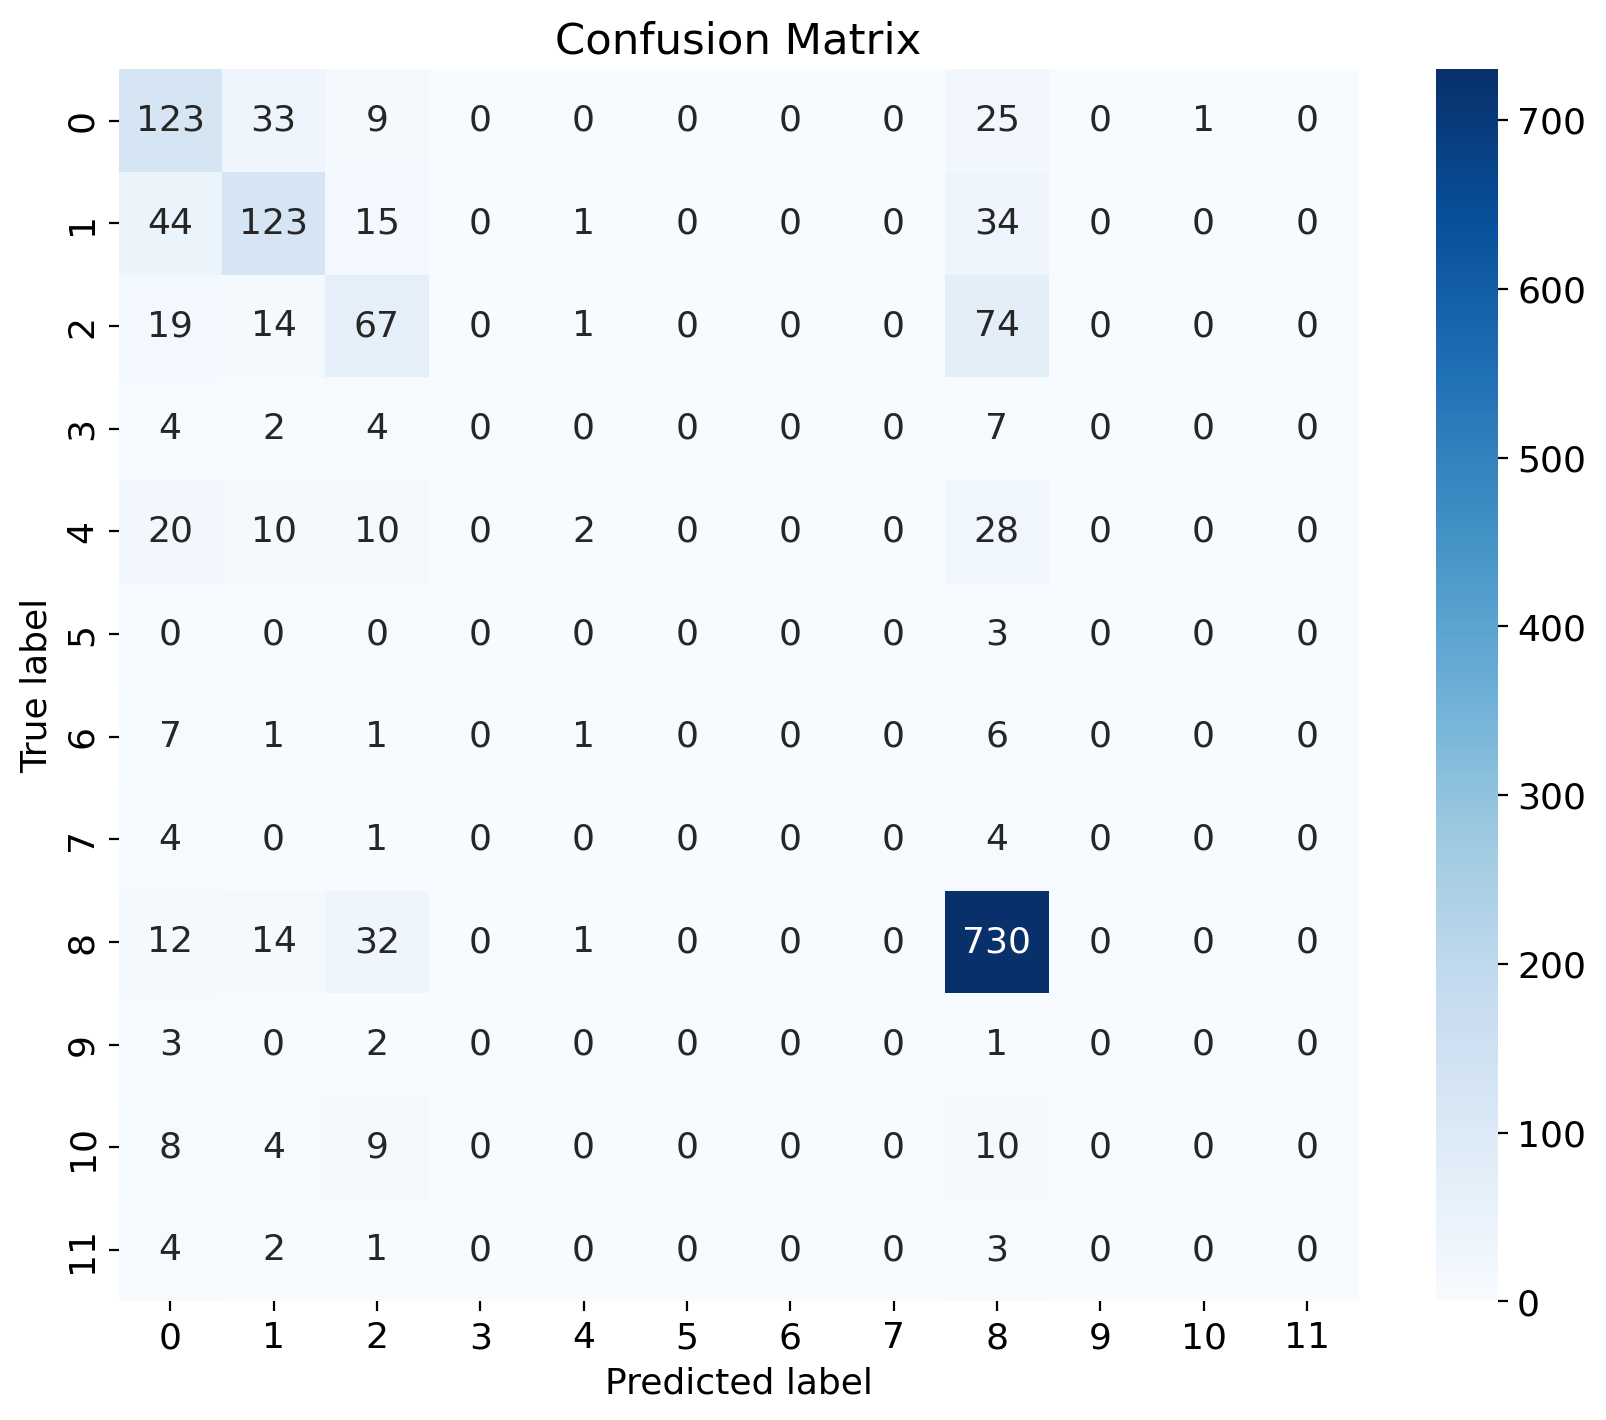

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# y_test_df and y_pred_df are your dataframes of shape (samples, 12)
# Each row: probabilistic assignment to each cause

# Get true and predicted cause labels by argmax across columns
y_true = np.argmax(y_test_df2.values, axis=1)
y_pred = np.argmax(y_pred_df.values, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(12))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


## Confusion Matrix Percentage

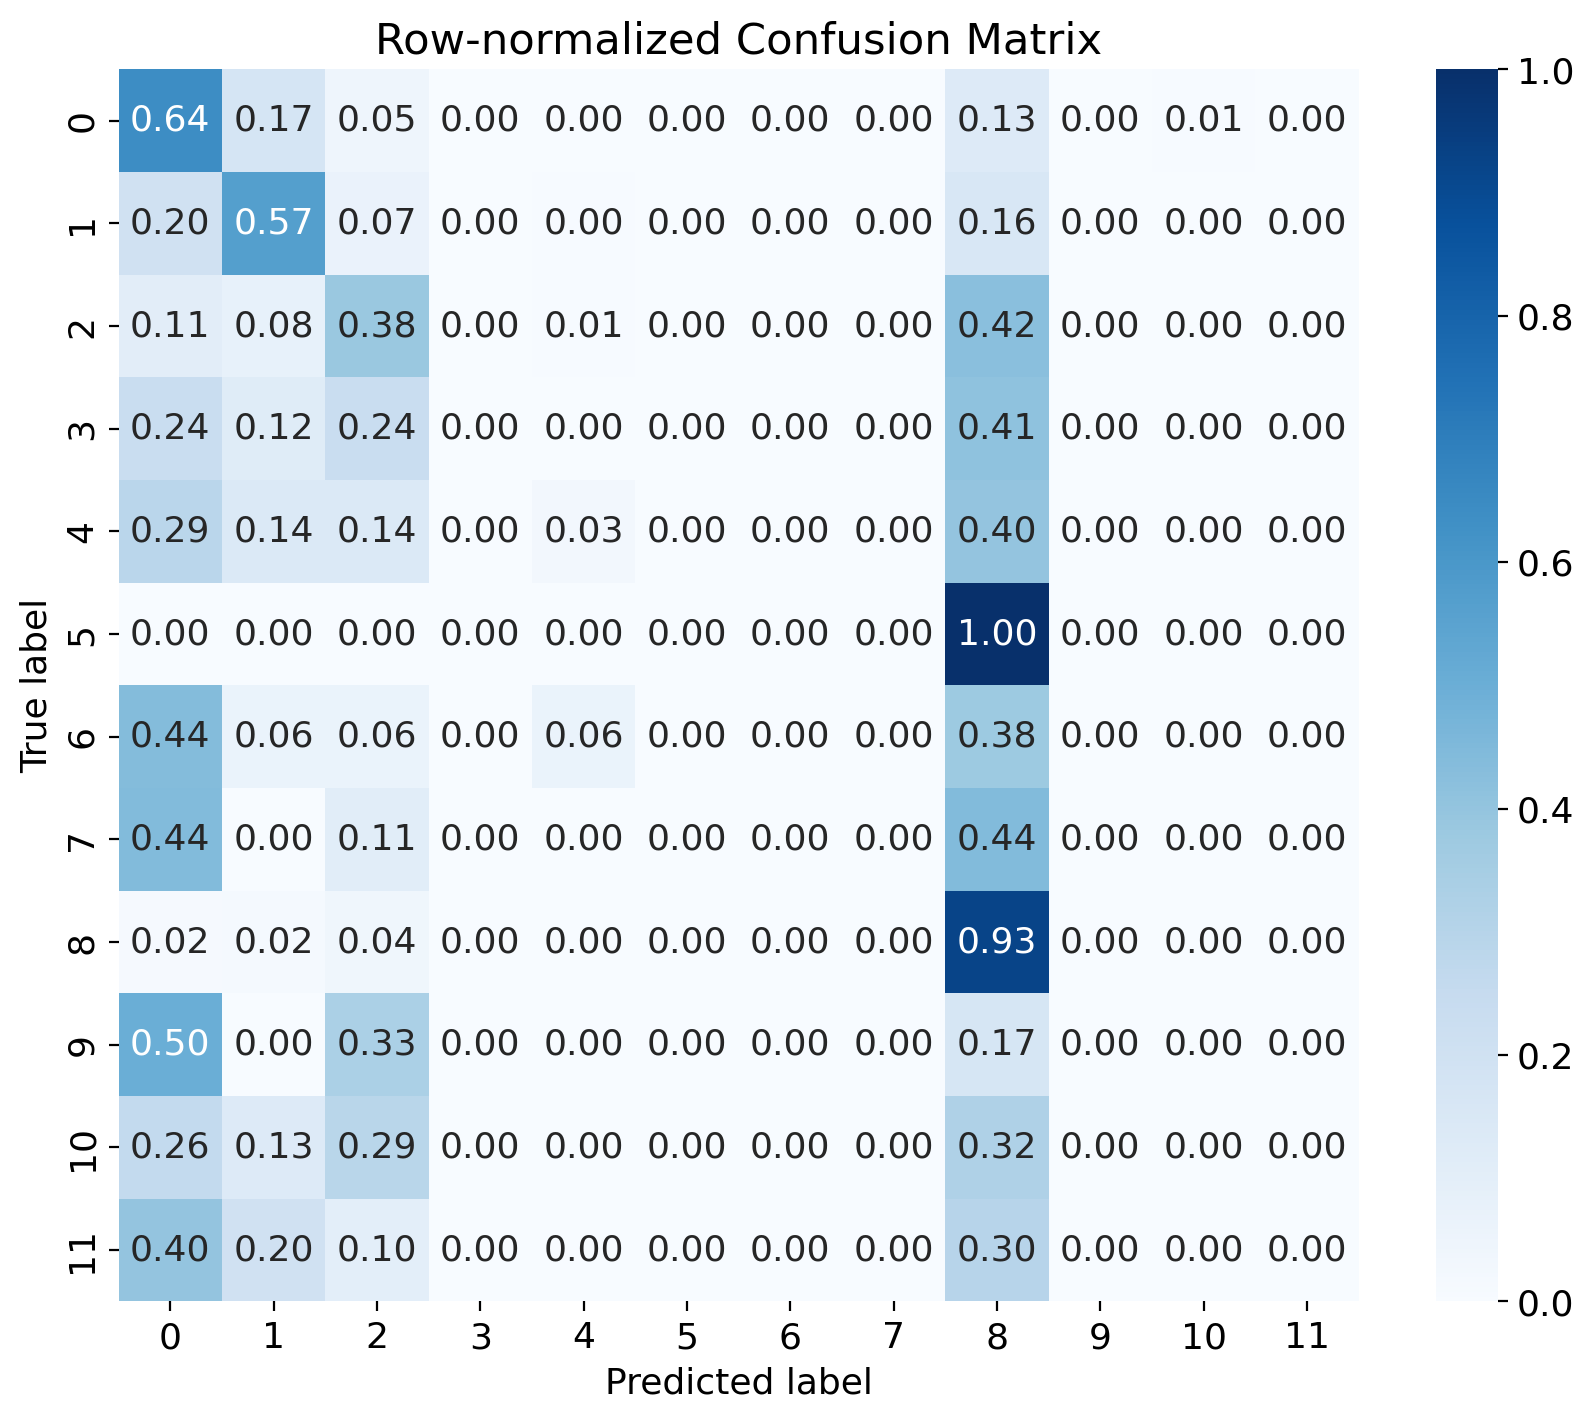

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Normalize so each row sums to 1 (handle zero rows to avoid division by zero)
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # avoid division by zero
cm_normalized = cm / row_sums

# Plot the normalized confusion matrix (values between 0 and 1)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=np.arange(12),
    yticklabels=np.arange(12)
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Row-normalized Confusion Matrix')
plt.show()


## Accuracy Table

In [38]:
# Calculate accuracy for each category (class-wise accuracy)
class_accuracies = cm.diagonal() / cm.sum(axis=1) *100

# Calculate overall accuracy
overall_accuracy = cm.diagonal().sum() / cm.sum()*100

# Create a DataFrame for better visualization
accuracy_table = pd.DataFrame({
    'Class': np.arange(12),
    'Class Accuracy': class_accuracies
})

# Append overall accuracy as a separate row
overall_row = pd.DataFrame({'Class': ['Overall'], 'Class Accuracy': [overall_accuracy]})
accuracy_table = pd.concat([accuracy_table, overall_row], ignore_index=True)

print(accuracy_table)

      Class  Class Accuracy
0         0       64.397906
1         1       56.682028
2         2       38.285714
3         3        0.000000
4         4        2.857143
5         5        0.000000
6         6        0.000000
7         7        0.000000
8         8       92.522180
9         9        0.000000
10       10        0.000000
11       11        0.000000
12  Overall       68.122555


## All Accuracies

In [45]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Assuming Natural is index 6, human = all others
natural_idx = 8
y_binary_true = (y_true == natural_idx).astype(int)      # 1 = Natural, 0 = Human
y_binary_pred = (y_pred == natural_idx).astype(int)

print(y_true.shape, y_pred.shape)
print(y_binary_true.shape, y_binary_pred.shape)


# Binary CM: [[TN, FP], [FN, TP]]
cm_binary = confusion_matrix(y_binary_true, y_binary_pred)

# Metrics
binary_accuracy = accuracy_score(y_binary_true, y_binary_pred)
precision_natural = precision_score(y_binary_true, y_binary_pred)
recall_natural = recall_score(y_binary_true, y_binary_pred)
f1_natural = f1_score(y_binary_true, y_binary_pred)

print("Binary CM (Human vs Natural):\n", cm_binary)
print(f"Binary Accuracy: {binary_accuracy:.1%}")
print(f"Natural Precision: {precision_natural:.1%}")
print(f"Natural Recall: {recall_natural:.1%}")
print(f"Natural F1: {f1_natural:.1%}")


(1534,) (1534,)
(1534,) (1534,)
Binary CM (Human vs Natural):
 [[550 195]
 [ 59 730]]
Binary Accuracy: 83.4%
Natural Precision: 78.9%
Natural Recall: 92.5%
Natural F1: 85.2%


# Gridsearch

In [23]:
def train_evaluate_model(hyperparams, patience = 20):
    n_neuron = hyperparams['n_neuron']
    activation = hyperparams['activation']
    learning_rate = hyperparams['learning_rate']
    dropout_p = hyperparams['dropout_p']
    num_epochs = hyperparams['num_epochs']
    
    # Build model layers dynamically as in your code
    layers = []
    layers.append(nn.Linear(X_train.shape[1], n_neuron))
    layers.append(getattr(nn, activation)())
    layers.append(nn.Dropout(dropout_p))
    for n in range(N_layers - 1):
        layers.append(nn.Linear(n_neuron, n_neuron))
        layers.append(getattr(nn, activation)())
        layers.append(nn.Dropout(dropout_p))
    layers.append(nn.Linear(n_neuron, y_train.shape[1]))
    model = nn.Sequential(*layers).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    criterion = nn.MSELoss()
    
    # Create dataloaders here or pass them in
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_loss


In [24]:
param_grid = {
    'n_neuron': [16, 32],
    'activation': ['ReLU'],
    'learning_rate': [0.0001, 0.001],
    'dropout_p': [0.1, 0.2],
    'num_epochs': [50]
}

best_hyperparams = None
lowest_val_loss = float('inf')

for n_neuron in param_grid['n_neuron']:
    for activation in param_grid['activation']:
        for lr in param_grid['learning_rate']:
            for dropout in param_grid['dropout_p']:
                hyperparams = {
                    'n_neuron': n_neuron,
                    'activation': activation,
                    'learning_rate': lr,
                    'dropout_p': dropout,
                    'num_epochs': 50,
                }
                val_loss = train_evaluate_model(hyperparams)
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    best_hyperparams = hyperparams

print(f'Best Hyperparams: {best_hyperparams} with Validation Loss: {lowest_val_loss}')


Best Hyperparams: {'n_neuron': 32, 'activation': 'ReLU', 'learning_rate': 0.001, 'dropout_p': 0.1, 'num_epochs': 50} with Validation Loss: 0.037643329985439775
